In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!nvidia-smi

Fri Apr 23 16:59:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    90W / 150W |   5392MiB /  7618MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [5]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=50,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


# 전이 학습

In [6]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

__________________________________________________________________________________________________
activation_130 (Activation)     (None, 7, 7, 160)    0           batch_normalization_130[0][0]    
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 7, 7, 192)    208896      block17_13_ac[0][0]              
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 7, 7, 192)    215040      activation_130[0][0]             
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 7, 7, 192)    576         conv2d_128[0][0]                 
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 7, 7, 192)    576         conv2d_131[0][0]                 
__________

In [7]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1769600   
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
activation_203 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3

# Fine Tuning

In [8]:
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['conv_7b', 'block8_10_conv']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

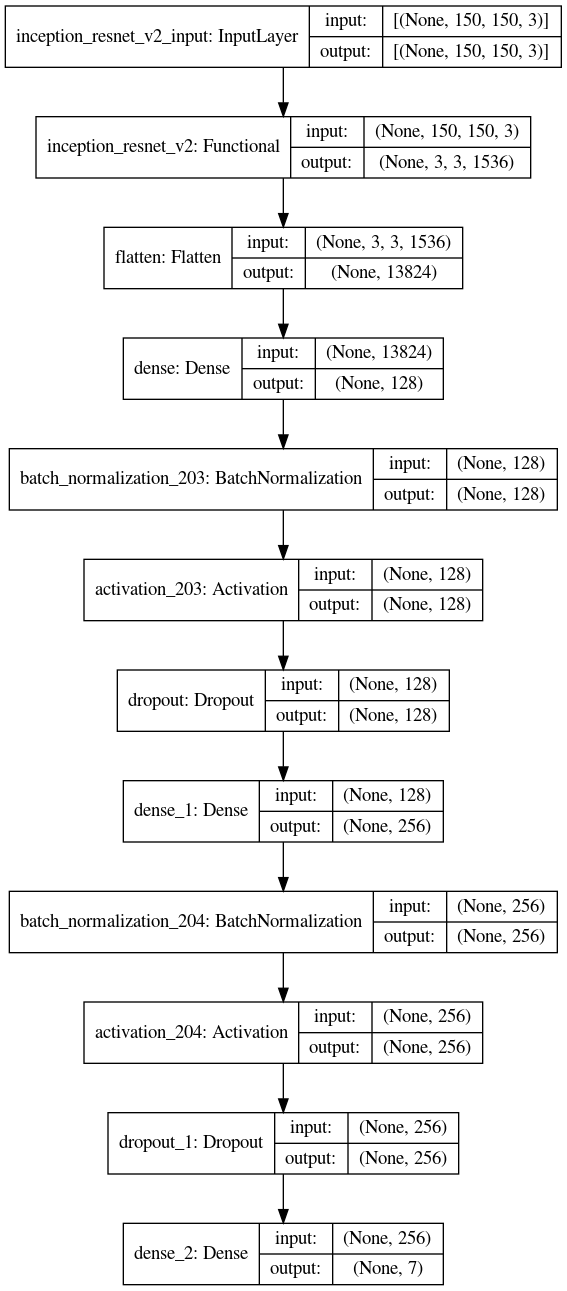

In [9]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/InceptionResNetV2_1/InceptionResNetV2_1-5.png')

In [10]:
history = model.fit(train_generator, steps_per_epoch=318, epochs=30,
                    validation_data=validation_generator, validation_steps=78)

Epoch 1/30
318/318 [==============================] - 203s 592ms/step - loss: 2.3400 - accuracy: 0.2168 - val_loss: 1.7247 - val_accuracy: 0.3692
Epoch 2/30
318/318 [==============================] - 193s 609ms/step - loss: 1.9766 - accuracy: 0.3225 - val_loss: 1.6264 - val_accuracy: 0.4103
Epoch 3/30
318/318 [==============================] - 192s 604ms/step - loss: 1.8328 - accuracy: 0.3667 - val_loss: 1.5727 - val_accuracy: 0.4256
Epoch 4/30
318/318 [==============================] - 148s 464ms/step - loss: 1.7749 - accuracy: 0.3764 - val_loss: 1.5354 - val_accuracy: 0.4433
Epoch 5/30
318/318 [==============================] - 131s 412ms/step - loss: 1.6820 - accuracy: 0.4079 - val_loss: 1.5110 - val_accuracy: 0.4472
Epoch 6/30
318/318 [==============================] - 130s 408ms/step - loss: 1.6327 - accuracy: 0.4238 - val_loss: 1.4789 - val_accuracy: 0.4621
Epoch 7/30
318/318 [==============================] - 130s 408ms/step - loss: 1.5590 - accuracy: 0.4460 - val_loss: 1.4689 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


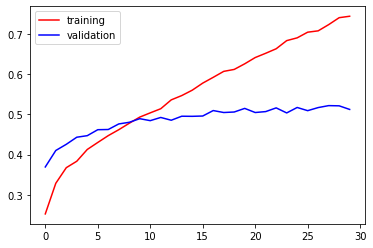

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-5_acc.jpg')
plt.show()

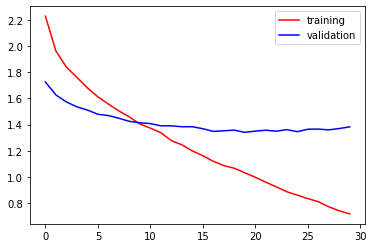

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-5_val.jpg')
plt.show()

In [13]:
result = model.evaluate(test_generator)
print(np.round(result, 4))

42/42 [==============================] - 7s 175ms/step - loss: 1.2706 - accuracy: 0.5448
[1.2706 0.5448]


In [14]:
model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-5.h5')